In [1]:
%matplotlib inline
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from collections import defaultdict
from itertools import groupby
from sklearn import datasets
from numpy import random
from scipy.stats import dirichlet, norm, poisson

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
random.seed(1234)

# Understanding Probabilistic Topic Models By Simulation

* Tim Hopper
* [@tdhopper](https://twitter.com/tdhopper)
* [stiglerdiet.com](http://www.stiglerdiet.com)
* Data Science at [Distil Networks](distilnetworks.com)

Slides available at http://bit.ly/lda-talk.

# What Is a Topic Model?

# What is Latent Dirichlet Allocation?

> LDA is a three-level hierarchical Bayesian model, in which each
item of a collection is modeled as a finite mixture over an underlying set of topics. 

> Each topic is, in turn, modeled as an infinite mixture over an underlying set of topic probabilities.

Duh.

[[source](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf)]

# What is Latent Dirichlet Allocation?

![](./static/lda.png)

Duh.

# What is Latent Dirichlet Allocation?

![](./static/graphical_model.png)

Duh.

# What is Latent Dirichlet Allocation?

$
p(D \,|\, \alpha, \beta) =
\prod_{d=1}^M \int p(\theta_d \,|\, \alpha )
\left(
\prod_{n=1}^{N_d}
\sum_{z_{dn}}
p(z_{dn} \,|\, \theta_d)
p(w_dn \,|\, z_dn, \beta)
\right)
d \theta_d
$

Duh.

![](./static/sheldon.gif)

In [2]:
iris = datasets.load_iris()
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df['class'] = iris['target']
df = df[df['class'].isin([0,2])]
gby = df.groupby(by='class')['sepal length (cm)']
hist_data = [gby.get_group(cid).tolist() 
             for cid in gby.groups.keys()]

settings = {"bins": 10, "histtype": 'stepfilled', "alpha": .5}
data = {"x": df['sepal length (cm)']}
data.update(settings)
data2 = {"x": hist_data }
data2.update(settings)
title = 'Sepal Length for Iris-Setosa and Iris-Virginica'

# Naive Clustering

Can we discriminate between Setosa and Virginica irises by modeling their sepal length as a mixture of Gaussians?

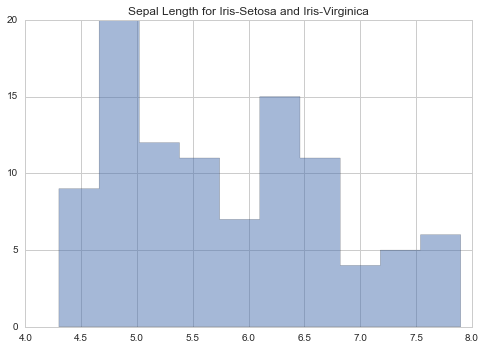

In [3]:
plt.hist(**data);_=plt.title(title)

# Naive Clustering

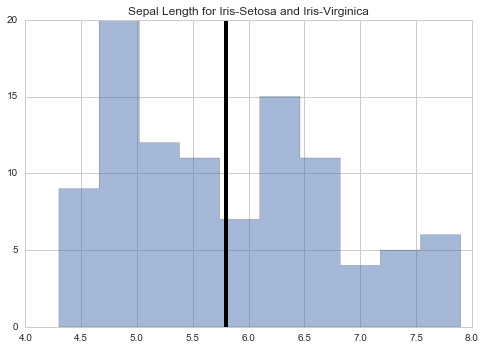

In [4]:
plt.hist(**data);plt.title(title);_=plt.axvline(5.8, color='black', linewidth=4)

# Gaussian Mixture Models

Here's what our actual underlying data looks like.

Without knowing the _latent_ classes, we could _assume_ that each class is drawn from a normal distribution.

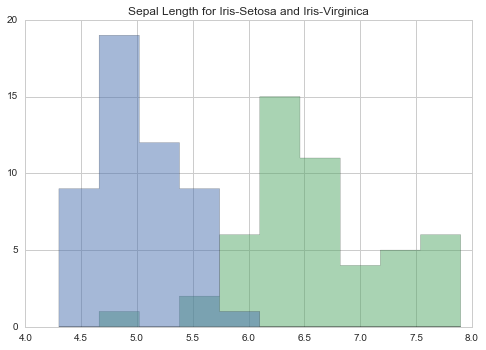

In [5]:
plt.hist(**data2);_=plt.title(title)

    ➡ Forward Sampling
Let's generate some data

In [6]:
# Fixed model parameters
mixture_proportion = [0.50, 0.50]
mean               = [5.01, 6.59]
std                = [0.35, 0.64]

data = []
for _ in range(100):
    iris_type = random.choice(2, p=mixture_proportion)
    sepal_length = norm(loc=mean[iris_type], 
                        scale=std[iris_type]
                       ).rvs()
    
    data.append((iris_type, sepal_length))

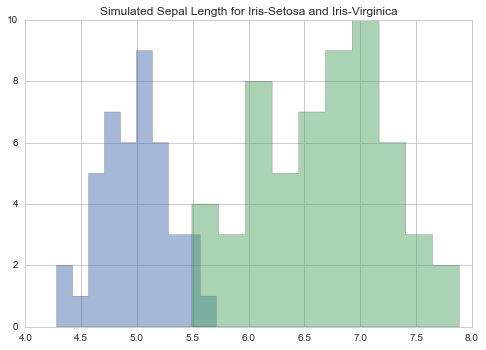

In [7]:
plt.hist([sepal_length for iris_type, sepal_length 
          in data if iris_type==0], **settings)
plt.hist([sepal_length for iris_type, sepal_length 
          in data if iris_type==1], **settings)
_=plt.title('Simulated Sepal Length for Iris-Setosa and Iris-Virginica')

    ➡ Forward Sampling    
Bayesian style!

In [8]:
# Distribution on parameters
mixture_proportion = dirichlet(alpha=[1, 1]).rvs()[0]
mean               = norm(loc=6, scale=1).rvs(size=2)
std                = norm(loc=.5, scale=.2).rvs(size=2)

data = []
for z in range(1, 101):
    iris_type = random.choice(2, p=mixture_proportion)
    sepal_length = norm(loc=mean[iris_type], 
                        scale=std[iris_type]
                       ).rvs()
    data.append((iris_type, sepal_length))

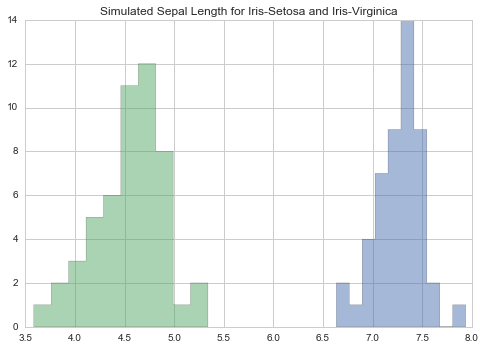

In [9]:
plt.hist([sepal_length for iris_type, sepal_length 
          in data if iris_type==0], **settings)
plt.hist([sepal_length for iris_type, sepal_length 
          in data if iris_type==1], **settings)
_=plt.title('Simulated Sepal Length for Iris-Setosa and Iris-Virginica')

    ➡ Forward Sampling
    
If we run sample again, our data looks completely different. These are samples from the distribution over this model.

In [10]:
# Distribution on parameters
mixture_proportion = dirichlet(alpha=[1, 1]).rvs()[0]
mean               = norm(loc=6, scale=1).rvs(size=2)
std                = norm(loc=.5, scale=.2).rvs(size=2)

data = []
for z in range(1, 101):
    iris_type = random.choice(2, p=mixture_proportion)
    sepal_length = norm(loc=mean[iris_type], scale=std[iris_type]).rvs()
    data.append((iris_type, sepal_length))

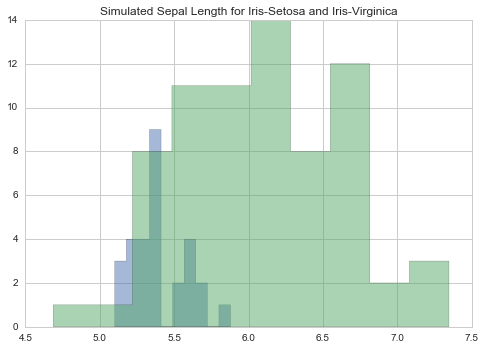

In [11]:
plt.hist([sepal_length for iris_type, sepal_length 
          in data if iris_type==0], **settings)
plt.hist([sepal_length for iris_type, sepal_length 
          in data if iris_type==1], **settings)
_=plt.title('Simulated Sepal Length for Iris-Setosa and Iris-Virginica')

    """
    ⬅ Reversing the Process
    """

Given data without cluster assignments (in no particular order)...

...find the cluster for each point

...find the parameters of each cluster (or distribution over parameters)

...find the mixture proportion (or distribution proportions)

----



You can do this with MCMC as in [PyMC3](https://github.com/pymc-devs/pymc3/blob/5317dd4ba1e413003aa80e9746e4e99143654183/docs/source/notebooks/gaussian_mixture_model.ipynb). See also [this notebook](http://nbviewer.ipython.org/github/tdhopper/notes-on-dirichlet-processes/blob/master/2015-09-02-fitting-a-mixture-model.ipynb).

# Discrete Mixture Model

There's nothing inheriently special about the normal distribution. (👈Not actually true.)

In [12]:
vocabulary = ['🐍', '🐼', '📊']
mixture_proportion = [0.3, 0.7]
cluster_distributions = [[0.33, 0.33, 0.34], 
                         [0.2, 0.8, 0.0], 
                         [0.5, 0.1, 0.4]]

docs = defaultdict(str)
for _ in range(100):
    cluster = random.choice(len(mixture_proportion), 
                            p=mixture_proportion)
    docs[cluster] += random.choice(vocabulary, 
                                   p=cluster_distributions[cluster])
    docs[cluster] = ''.join(sorted(docs[cluster]))

In [13]:
for cluster, doc in docs.items():
    print("Cluster {}: ".format(cluster+1), doc)

Cluster 1:  🐍🐍🐍🐍🐍🐍🐍🐍🐼🐼🐼🐼🐼📊📊📊📊📊📊📊📊📊📊
Cluster 2:  🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼


    ➡ Forward Sampling    
Bayesian style!

In [14]:
vocabulary = ['🐍', '🐼', '📊']
num_clusters = 2
mixture_proportion = dirichlet(alpha=num_clusters*[1]).rvs()[0]
cluster_distributions = (dirichlet(alpha=[1, 1, 1])
                         .rvs(size=num_clusters))

docs = defaultdict(str)
for _ in range(100):
    cluster = random.choice(num_clusters, 
                            p=mixture_proportion)
    docs[cluster] += random.choice(vocabulary, 
                                   p=cluster_distributions[cluster])
    docs[cluster] = ''.join(sorted(docs[cluster]))

In [15]:
for cluster, doc in docs.items():
    print(end="Cluster {}: ".format(cluster+1))
    print(doc)

Cluster 1: 🐍
Cluster 2: 🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼🐼📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊


### Excursis: Bag of Words Assumption

In [16]:
import collections
this = 'beautiful is better than ugly explicit is better than implicit simple is better than complex complex is better than complicated flat is better than nested sparse is better than dense readability counts special cases arent special enough to break the rules although practicality beats purity errors should never pass silently unless explicitly silenced in the face of ambiguity refuse the temptation to guess there should be one and preferably only one obvious way to do it although that way may not be obvious at first unless youre dutch now is better than never although never is often better than right now if the implementation is hard to explain its a bad idea if the implementation is easy to explain it may be a good idea namespaces are one honking great idea lets do more of those'
' '.join(sorted(this.split(' ')))

'a a although although although ambiguity and are arent at bad be be be beats beautiful better better better better better better better better break cases complex complex complicated counts dense do do dutch easy enough errors explain explain explicit explicitly face first flat good great guess hard honking idea idea idea if if implementation implementation implicit in is is is is is is is is is is it it its lets may may more namespaces nested never never never not now now obvious obvious of of often one one one only pass practicality preferably purity readability refuse right rules should should silenced silently simple sparse special special temptation than than than than than than than than that the the the the the there those to to to to to ugly unless unless way way youre'

### Excursis: Bag of Words Assumption

![](static/blei-f1.jpg)

[source](http://cacm.acm.org/magazines/2012/4/147361-probabilistic-topic-models/fulltext)

## Mixture Model for Documents (Grouped Data)


In [17]:
vocabulary = ['🐍', '🐼', '📊']; 
boring_vocabulary = [':snake:', ':panda_face:', ':bar_chart:']
num_terms = len(vocabulary)

# Topics are distributions over vocabulary words
topic_labels = ['☀', '☁']
boring_topics = [':sunny:', ':cloud:']
topics = [[ 0.1,  0.3,  0.6],
          [ 0.8,  0.1,  0.1]]

# Proportion of documents of each topic
mixture_proportion = [0.3, 0.7]

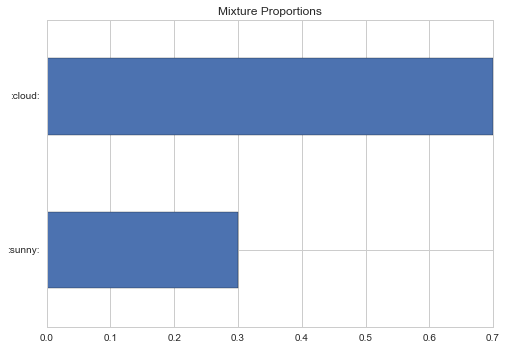

In [18]:
pd.Series(mixture_proportion, index=boring_topics).plot(kind='barh')
_=plt.title("Mixture Proportions")

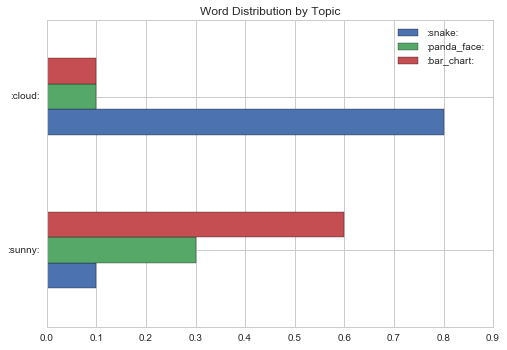

In [19]:
pd.DataFrame(topics, columns=boring_vocabulary, index=boring_topics).plot(kind='barh')
_=plt.title("Word Distribution by Topic")

    ➡ Forward Sampling
Let's generate some documents!

In [20]:
for doc_index in range(1, 11):
    topic = random.choice(topic_labels, p=mixture_proportion)
    doc_len = poisson(mu=10).rvs(size=1)
    doc = sorted([random.choice(vocabulary, 
                                   p=topics[topic_labels.index(topic)]) 
                  for _ in range(doc_len)])
    print("Document {:02d} (topic {}): {}".format(doc_index, topic, ''.join(doc)))

Document 01 (topic ☁): 🐍🐍🐍🐍🐍🐍📊
Document 02 (topic ☁): 🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐼🐼
Document 03 (topic ☁): 🐍🐍🐍🐍
Document 04 (topic ☀): 🐍🐼🐼📊📊📊📊📊📊
Document 05 (topic ☀): 🐼🐼🐼📊📊📊📊📊
Document 06 (topic ☁): 🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐼🐼🐼
Document 07 (topic ☁): 🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐍🐼🐼
Document 08 (topic ☀): 🐼🐼🐼📊📊📊📊📊📊📊📊📊
Document 09 (topic ☀): 🐼🐼📊📊📊📊📊📊📊
Document 10 (topic ☀): 🐼🐼🐼🐼📊📊📊📊📊📊📊📊


    """
    ⬅ Reversing the Process
    """

Given a collection of documents...

...find the topic for each document

...find the distribution over topics

...find the distribution over terms for each topic

    """
    ⬅ Limitations of this Model
    """
    
* __Single topic per document.__
* Word order irrelevant. (Bag-of-words assumption!)
* Assumes we know # of topics!

```
➡ What if we sample the topic for each word?
```

In [21]:
# recycle our `topics` sampled from the Dirichlet distribution

docs = defaultdict(lambda: defaultdict(str))
for doc_index in range(10):
    doc_len = poisson(mu=10).rvs(size=1)
    mixture_proportion = dirichlet([0.5, 0.5]).rvs()[0]
    
    for word in range(doc_len):
        topic = random.choice(topic_labels, 
                                 p=mixture_proportion)
        word_dist = topics[topic_labels.index(topic)]
        word = random.choice(vocabulary, 
                                p=word_dist)
        docs[doc_index+1][topic] += word
        
        docs[doc_index+1][topic] = ''.join(sorted(docs[doc_index+1][topic]))

```
⬆ Generative model for latent dirichlet allocation
```

In [22]:
for doc_id, doc in docs.items():
    print("Doc {:02d}".format(doc_id))
    for topic, words in doc.items():
        print("  Words from topic {}: {}".format(topic, words))

Doc 01
  Words from topic ☁: 🐍🐍🐍🐍🐍🐼
  Words from topic ☀: 🐼🐼📊📊📊📊
Doc 02
  Words from topic ☁: 🐍🐍🐍
  Words from topic ☀: 🐍📊📊📊
Doc 03
  Words from topic ☁: 🐍📊
  Words from topic ☀: 🐼🐼📊📊📊📊
Doc 04
  Words from topic ☀: 🐍🐼🐼🐼🐼📊
Doc 05
  Words from topic ☁: 🐍🐍🐍🐍🐍🐍🐼📊
  Words from topic ☀: 🐼
Doc 06
  Words from topic ☀: 🐍🐍🐍🐼🐼🐼🐼🐼🐼📊📊📊📊📊📊📊📊📊📊📊📊📊
Doc 07
  Words from topic ☁: 🐍🐍🐍🐍🐍🐍🐼
  Words from topic ☀: 🐼📊
Doc 08
  Words from topic ☁: 📊
  Words from topic ☀: 🐼📊📊📊📊📊
Doc 09
  Words from topic ☀: 🐍🐍🐼🐼🐼🐼🐼📊📊📊📊📊📊
Doc 10
  Words from topic ☁: 🐍🐍🐍🐍🐼
  Words from topic ☀: 📊📊📊


### Excursis: Multi-topic documents

![](static/buffalo.png)

[source](https://en.wikipedia.org/wiki/Buffalo_buffalo_Buffalo_buffalo_buffalo_buffalo_Buffalo_buffalo)

    """
    ⬅ Reversing the Process
    """

Given a collection of documents...

Given each word in each document...

...find the topic for each __word__

...find the distribution over topics for each __document__

...find the distribution over terms for each topic

------
You can do this with MCMC (Gibbs sampling), variational inference, etc. 

    """
    ⬅ Limitations of this Model
    """

* <strike>Single topic per document.</strike>
* Word order irrelevant. 
    * (See Hanna Wallach's work for possible ideas.)
* Assumes we know # of topics!
    * (See hierarchical Dirichlet process models ideas.)

(There are more.)

# Questions?


-------

* Tim Hopper
* [@tdhopper](https://twitter.com/tdhopper)
* [stiglerdiet.com](http://www.stiglerdiet.com)

------

Read More:

* [Probabilistic Topic Models](http://cacm.acm.org/magazines/2012/4/147361-probabilistic-topic-models/fulltext) by David Blei, 2012
* [Introduction to Latent Dirichlet Allocation](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/) by Edwin Chen
* [lda package](https://github.com/ariddell/lda) by Allen Riddell
* [pyLDAvis package](https://pyldavis.readthedocs.org/en/latest/) by Ben Mabey [(example notebook)](http://nbviewer.ipython.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb)
* [Finding Scientific Topics](http://psiexp.ss.uci.edu/research/papers/sciencetopics.pdf) by Thomas L. Griffiths and Mark Steyvers

-----


